In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install scikit-learn==1.0.2
!pip install xgboost==1.7.6
!pip install catboost==1.2

from IPython import get_ipython
from IPython.display import display
# %%
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Load datasets
traffic_df = pd.read_csv('/content/Traffic.csv')
traffic_two_month_df = pd.read_csv('/content/TrafficTwoMonth.csv')

In [ ]:
traffic_df['Traffic Situation'].value_counts()


Traffic Situation
normal    1669
heavy      682
high       321
low        304
Name: count, dtype: int64

In [ ]:
# Combine datase
traffic_two_month_df['Source'] = 'TwoMonth'
traffic_df['Source']  = 'OneMonth'
combined_df = pd.concat([traffic_df, traffic_two_month_df], ignore_index=True)

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               8928 non-null   object
 1   Date               8928 non-null   int64 
 2   Day of the week    8928 non-null   object
 3   CarCount           8928 non-null   int64 
 4   BikeCount          8928 non-null   int64 
 5   BusCount           8928 non-null   int64 
 6   TruckCount         8928 non-null   int64 
 7   Total              8928 non-null   int64 
 8   Traffic Situation  8928 non-null   object
 9   Source             8928 non-null   object
dtypes: int64(6), object(4)
memory usage: 697.6+ KB


In [ ]:
def p_null_data(data):
    null_data = data.isna().sum()
    null_percent = data.isna().sum() / len(data)
    null_percent = null_percent.apply(lambda x: f'{x:.1%}')
    print("Total duplicated data count: ", data.duplicated().sum())
    result = pd.concat([null_data, null_percent], axis=1)
    result.columns = ['Null Data Count', 'Null Percentage']
    return result
p_null_data(combined_df)

Total duplicated data count:  0


Null Data Count Null Percentage
Time                             0            0.0%
Date                             0            0.0%
Day of the week                  0            0.0%
CarCount                         0            0.0%
BikeCount                        0            0.0%
BusCount                         0            0.0%
TruckCount                       0            0.0%
Total                            0            0.0%
Traffic Situation                0            0.0%
Source                           0            0.0%

In [ ]:
# Replace the "high" class with "heavy" in the "Traffic Situation" column
combined_df["Traffic Situation"] = combined_df["Traffic Situation"].replace("high", "heavy")

In [ ]:
combined_df['Traffic Situation'].value_counts()


Traffic Situation
normal    5279
heavy     2511
low       1138
Name: count, dtype: int64

In [ ]:
import plotly.express as px # Import the plotly.express module and assign it to the alias 'px'


In [ ]:
# 3. Distribution of traffic situations
fig = px.pie(combined_df, names='Traffic Situation', title='Traffic Situation Distribution', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation Distribution', title_x=0.5, template='plotly_white')
fig.show()

In [ ]:
def hstplt(data, features):
    plt.figure(figsize=(9, 3))
    sns.histplot(data, x=features, hue='Traffic Situation', kde=True)
    plt.xlabel(features)
    plt.ylabel("Traffic Situation")
    plt.title(f"Histplot between {features} and Traffic Situation")
    plt.show()

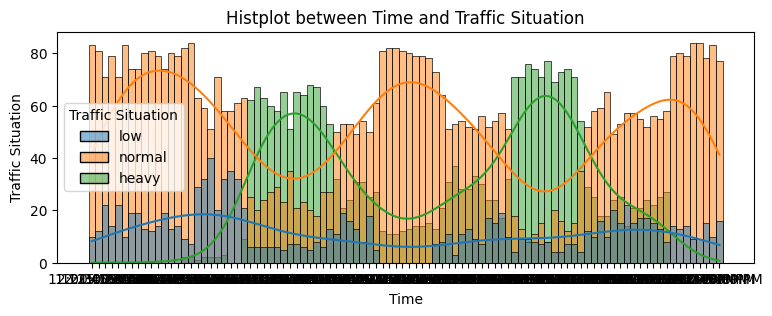

------------------------------------------------------------------------------------------


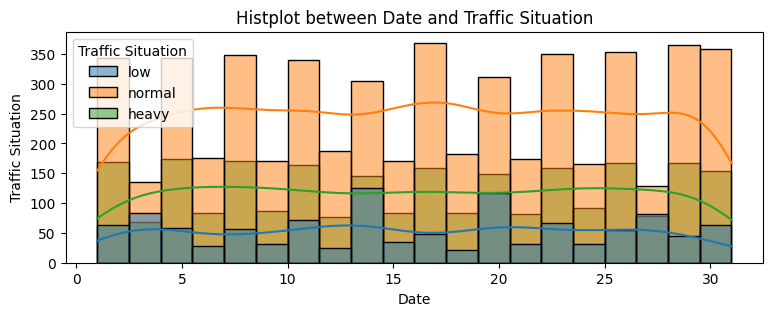

------------------------------------------------------------------------------------------


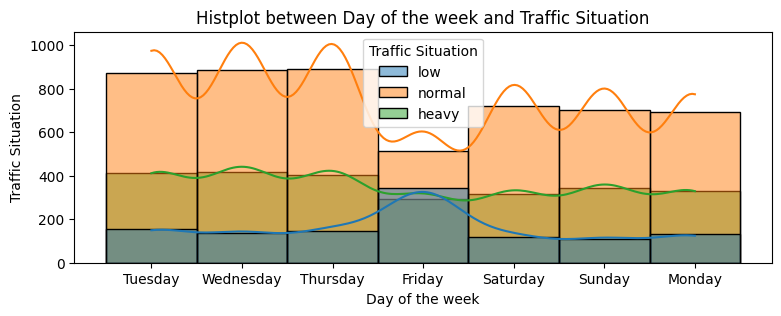

------------------------------------------------------------------------------------------


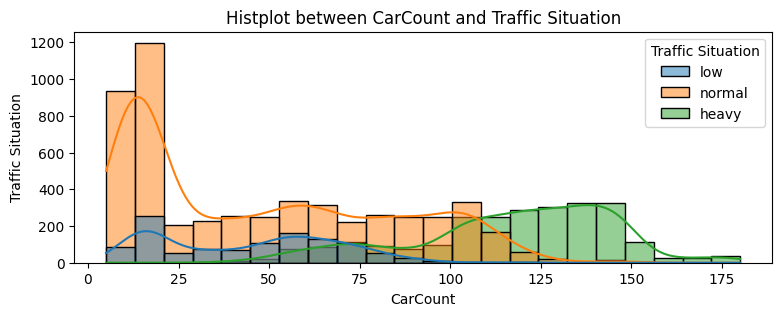

------------------------------------------------------------------------------------------


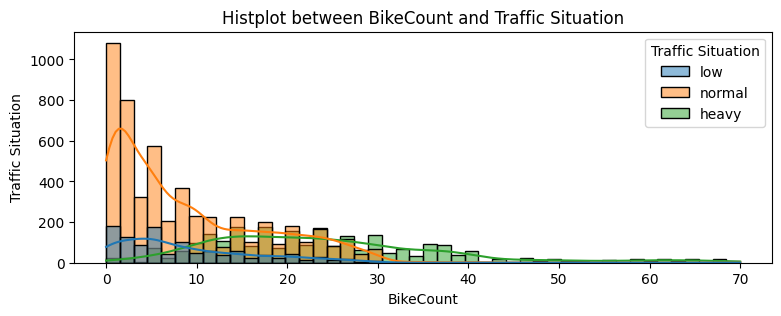

------------------------------------------------------------------------------------------


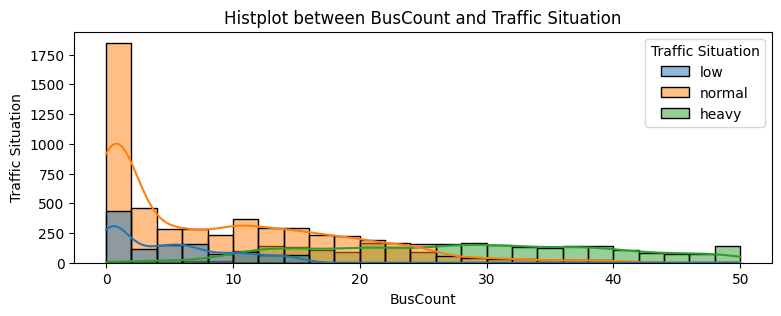

------------------------------------------------------------------------------------------


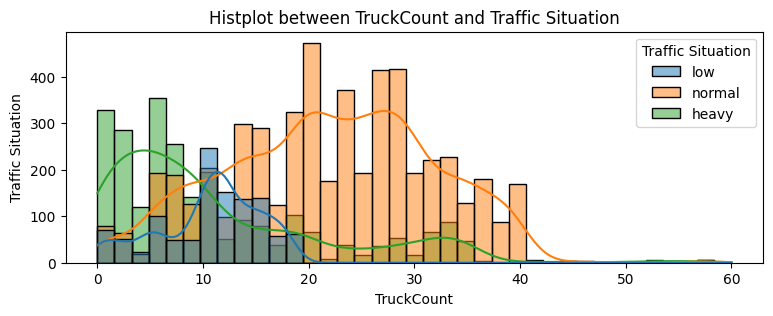

------------------------------------------------------------------------------------------


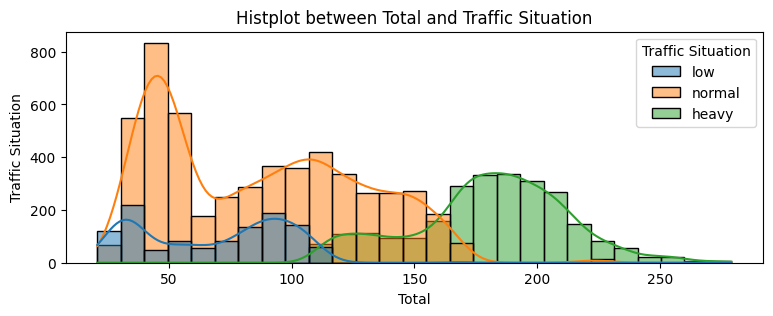

------------------------------------------------------------------------------------------


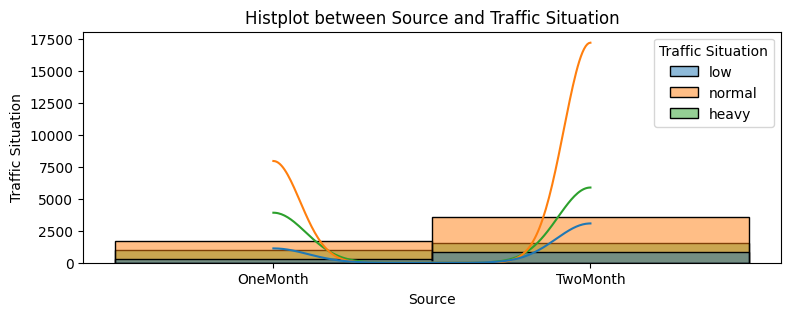

------------------------------------------------------------------------------------------


In [ ]:
for i in combined_df:
    if i == 'Traffic Situation':
        continue
    hstplt(combined_df, i)
    print('---' * 30)

In [ ]:
print(combined_df.columns)


Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation', 'Source'],
      dtype='object')


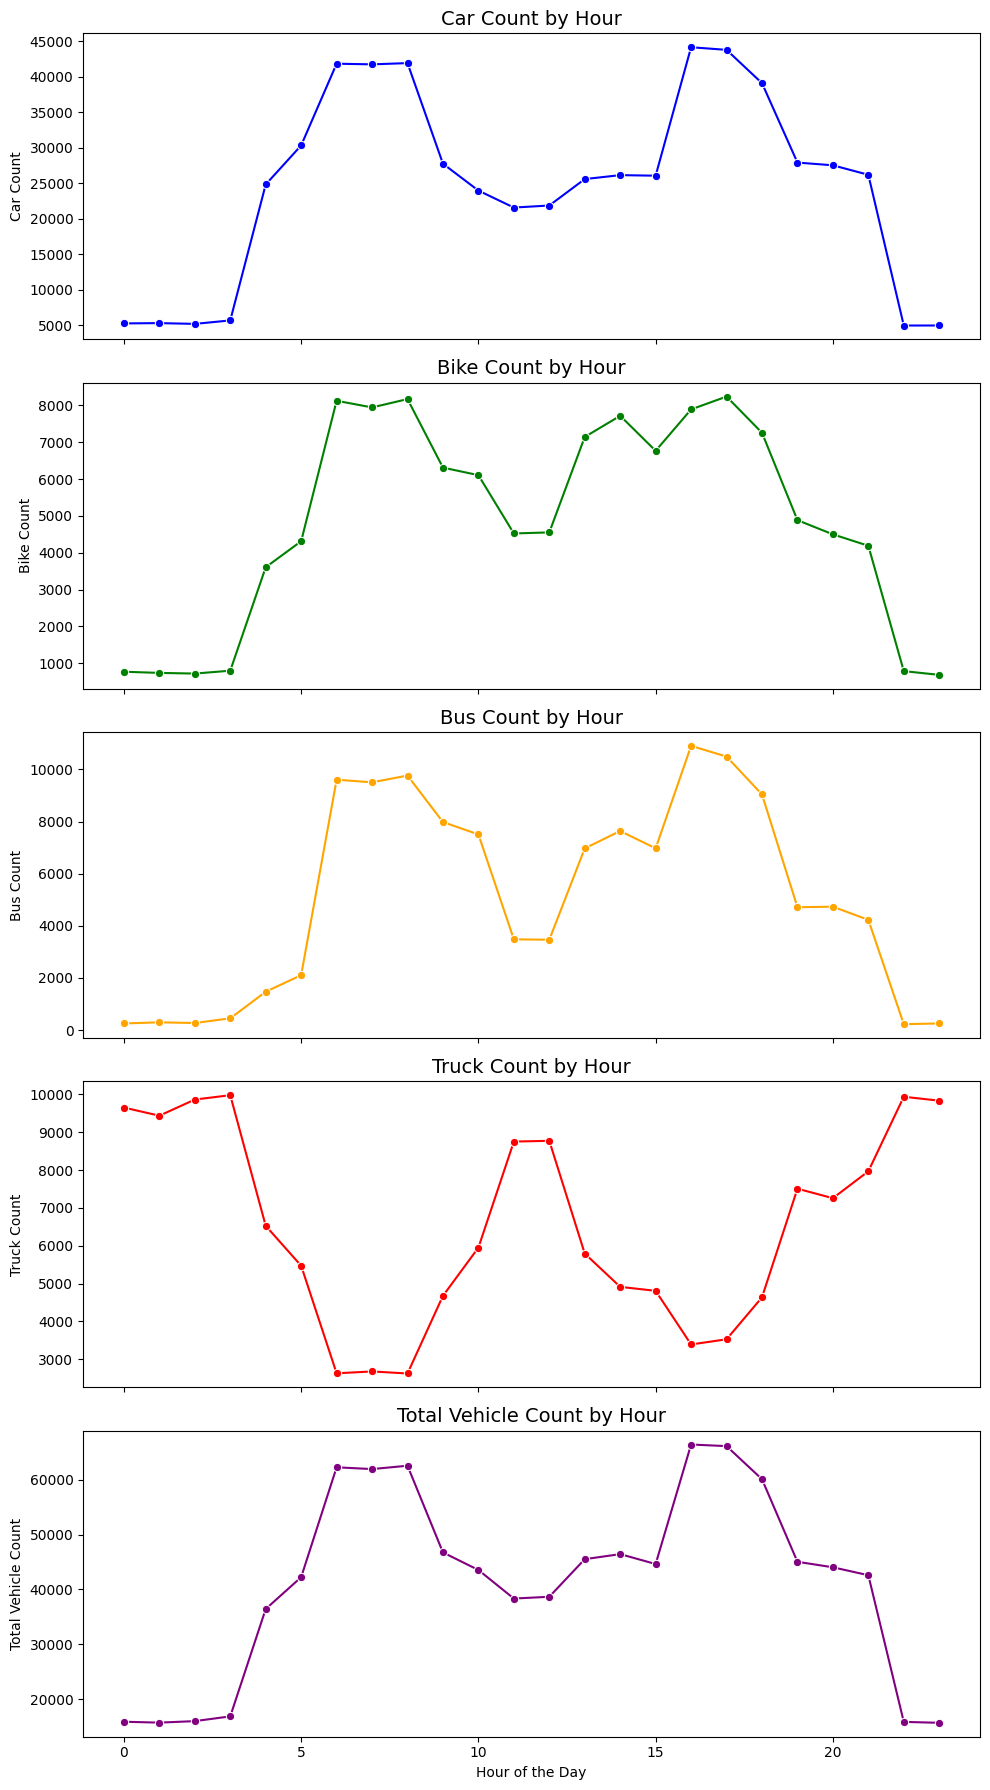

In [ ]:


# Check if 'Time' column exists in the DataFrame
if 'Time' not in combined_df.columns:
    raise KeyError("The 'Time' column is missing from the DataFrame. Please check the column names.")

# Ensure the 'Time' column is in datetime format and extract the hour
combined_df['Hour'] = pd.to_datetime(combined_df['Time'], format='%I:%M:%S %p').dt.hour

# Select only numeric columns for summation
numeric_columns = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
missing_columns = [col for col in numeric_columns if col not in combined_df.columns]

if missing_columns:
    raise KeyError(f"The following columns are missing from the DataFrame: {missing_columns}")

# Group by hour and sum the vehicle counts
hourly_data = combined_df.groupby('Hour')[numeric_columns].sum()

# Set the figure size and layout for separate plots
fig, axes = plt.subplots(5, 1, figsize=(10, 18), sharex=True)

# Define a dictionary for column plotting details
plot_details = {
    'CarCount': ('Car Count', 'blue'),
    'BikeCount': ('Bike Count', 'green'),
    'BusCount': ('Bus Count', 'orange'),
    'TruckCount': ('Truck Count', 'red'),
    'Total': ('Total Vehicle Count', 'purple'),
}

# Loop through columns and plot
for i, (col, (title, color)) in enumerate(plot_details.items()):
    sns.lineplot(x=hourly_data.index, y=hourly_data[col], ax=axes[i], color=color, marker='o')
    axes[i].set_title(f'{title} by Hour', fontsize=14)
    axes[i].set_ylabel(title)
    if col == 'Total':
        axes[i].set_xlabel('Hour of the Day')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


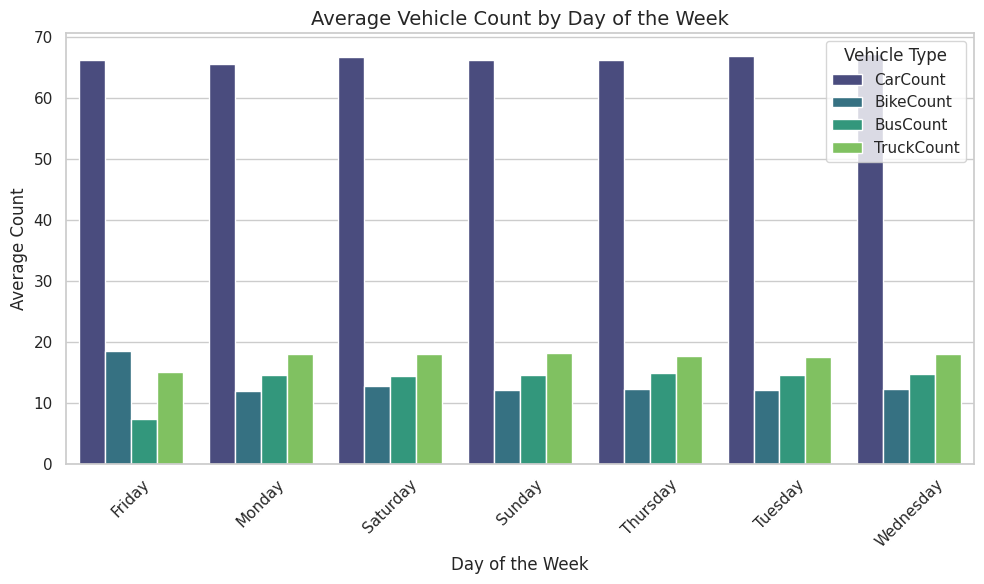

In [ ]:
# Select only numeric columns, and then choose the specific columns you want
numeric_columns = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']

# Group by 'Day of the week' and calculate the mean for only the selected numeric columns
grouped_combined_df = combined_df.groupby('Day of the week')[numeric_columns].mean()

# Reset the index to make 'Day of the week' a column again
grouped_combined_df = grouped_combined_df.reset_index()

# Use the melt function to reshape the DataFrame for seaborn
grouped_combined_df_melted = pd.melt(grouped_combined_df, id_vars='Day of the week', var_name='Vehicle Type', value_name='Count')

# Set plot style and size
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the barplot
sns.barplot(x='Day of the week', y='Count', hue='Vehicle Type', data=grouped_combined_df_melted, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add title and labels
plt.title('Average Vehicle Count by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Count', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

EDA

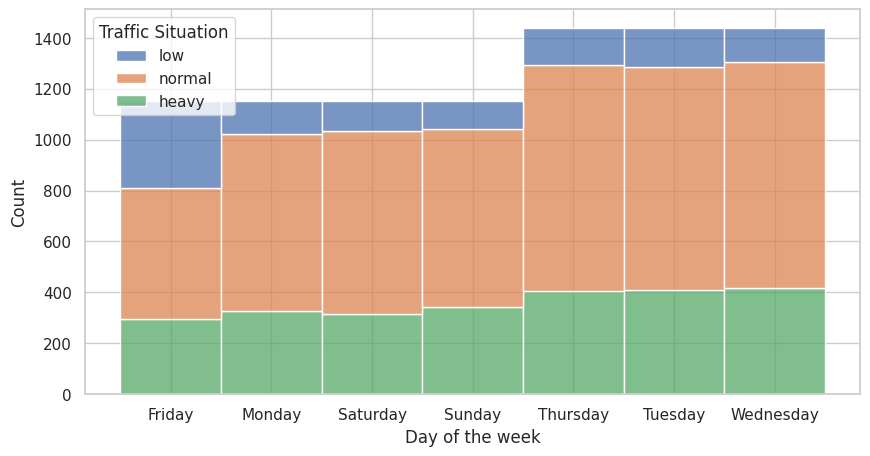

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Convert 'Day of the week' to a categorical type (if not already)
combined_df['Day of the week'] = pd.Categorical(combined_df['Day of the week'])

# Create a histogram with 'Day of the week' and 'Traffic Situation'
sns.histplot(data=combined_df, x="Day of the week", hue="Traffic Situation", multiple="stack")

# Show the plot
plt.show()

<Axes: xlabel='Date', ylabel='Count'>

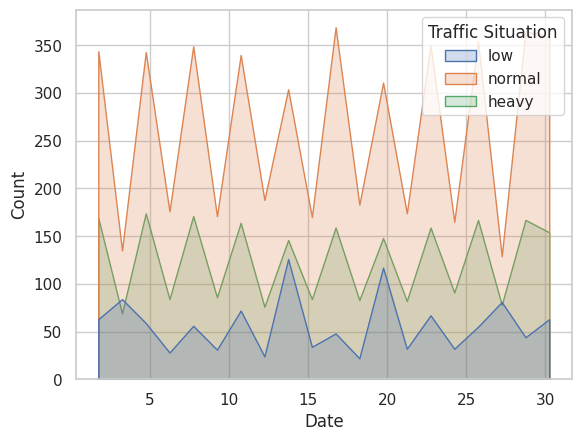

In [ ]:
sns.histplot(combined_df, x="Date", hue="Traffic Situation", element="poly")


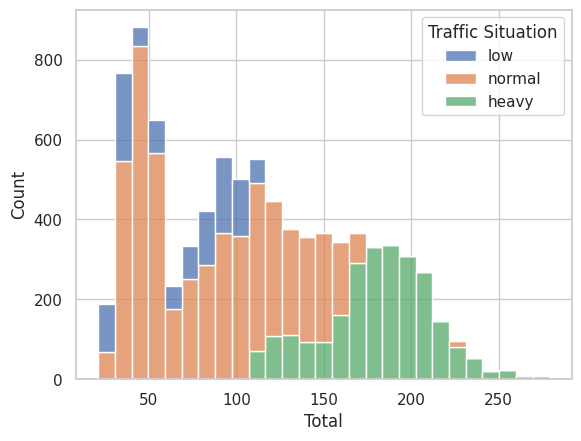

In [ ]:
# Check if 'Total' exists and has valid data
if 'Total' in combined_df.columns:
    if pd.api.types.is_numeric_dtype(combined_df['Total']):
        sns.histplot(data=combined_df, x="Total", hue="Traffic Situation", multiple="stack")
        plt.show()
    else:
        print("'Total' column is not numeric. Please convert it to numeric.")
else:
    print("'Total' column does not exist in the DataFrame.")


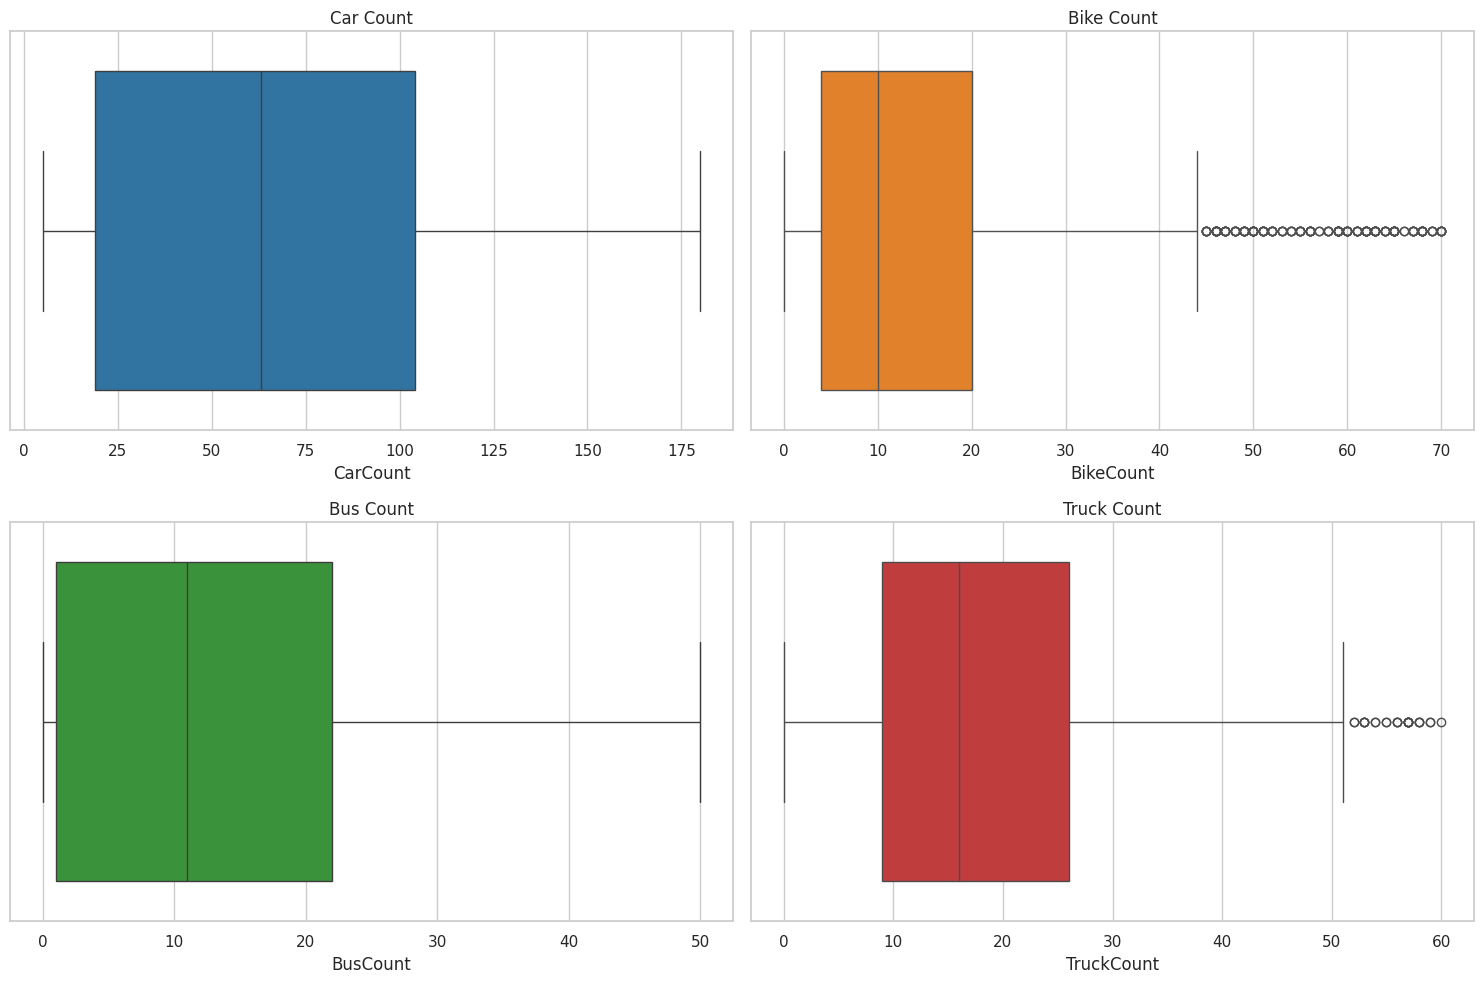

In [ ]:
# Plot boxplots to visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Replace 'combined_combined_df' with 'combined_df'
sns.boxplot(data=combined_df, x='CarCount', ax=axes[0, 0], color='#1f77b4')
sns.boxplot(data=combined_df, x='BikeCount', ax=axes[0, 1], color='#ff7f0e')
sns.boxplot(data=combined_df, x='BusCount', ax=axes[1, 0], color='#2ca02c')
sns.boxplot(data=combined_df, x='TruckCount', ax=axes[1, 1], color='#d62728')
axes[0, 0].set_title('Car Count')
axes[0, 1].set_title('Bike Count')
axes[1, 0].set_title('Bus Count')
axes[1, 1].set_title('Truck Count')
plt.tight_layout()
plt.show()

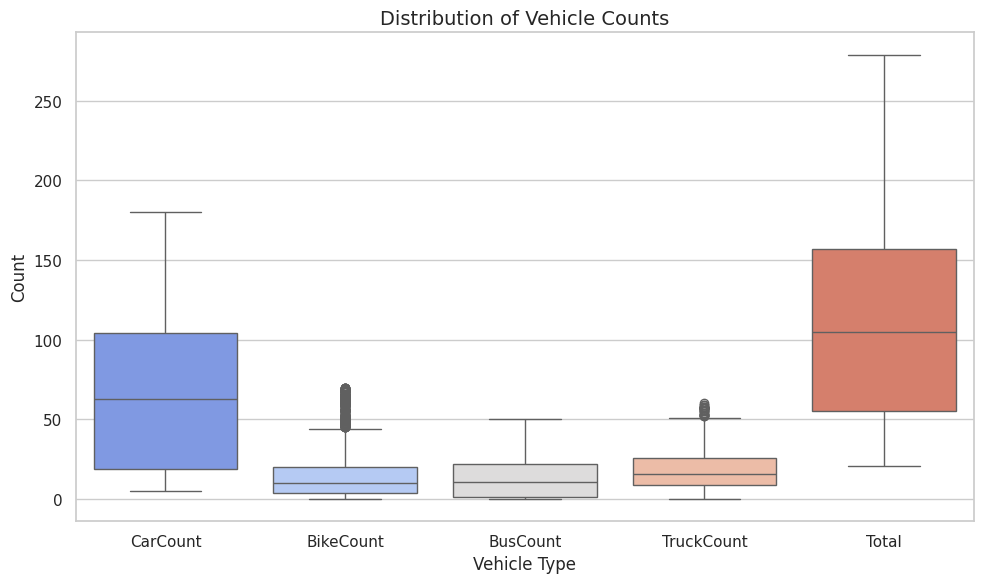

In [ ]:
# Boxplot for distribution of vehicle counts
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']], palette='coolwarm')

plt.title('Distribution of Vehicle Counts', fontsize=14)
plt.xlabel('Vehicle Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

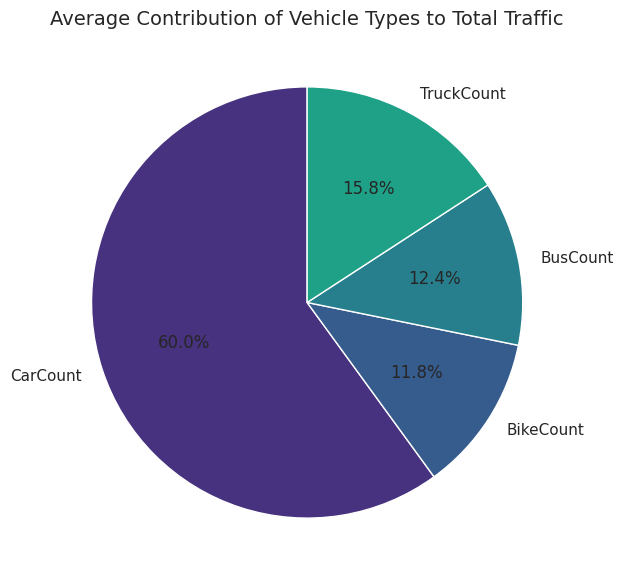

In [ ]:
# Pie chart for average contribution of each vehicle type to total traffic
average_vehicle_counts = combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']].mean()

plt.figure(figsize=(7, 7))
plt.pie(average_vehicle_counts, labels=average_vehicle_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))

plt.title('Average Contribution of Vehicle Types to Total Traffic', fontsize=14)
plt.show()

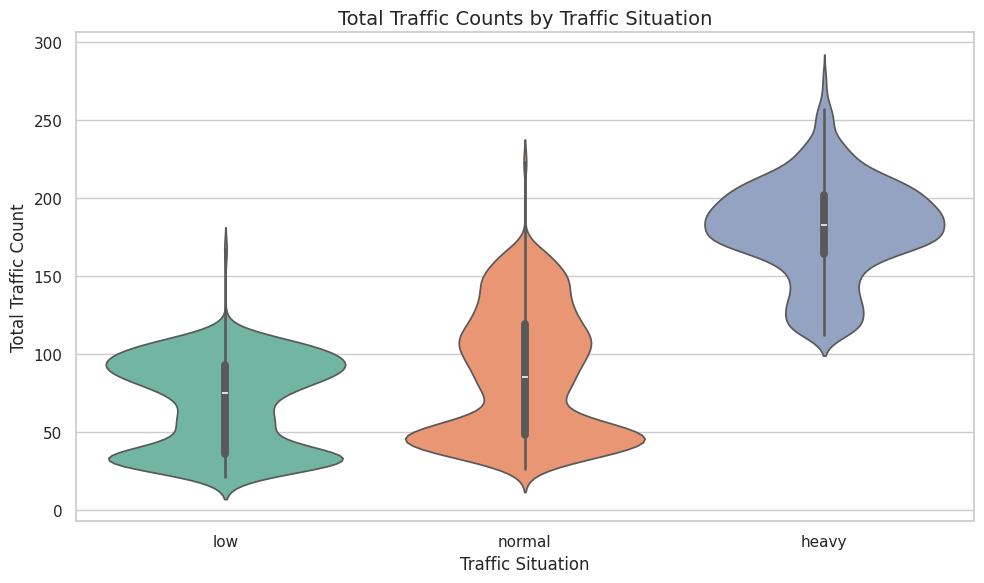

In [ ]:
# Violin plot for vehicle counts by traffic situation
plt.figure(figsize=(10, 6))
sns.violinplot(x='Traffic Situation', y='Total', data=combined_df, palette='Set2')

plt.title('Total Traffic Counts by Traffic Situation', fontsize=14)
plt.xlabel('Traffic Situation', fontsize=12)
plt.ylabel('Total Traffic Count', fontsize=12)

plt.tight_layout()
plt.show()

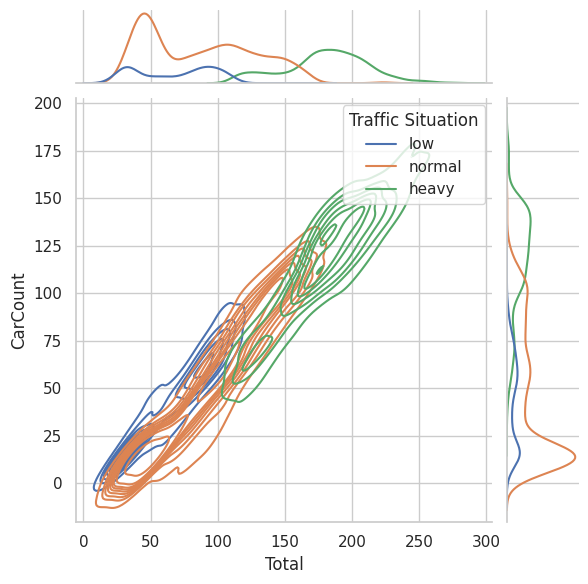

In [ ]:
# Check if 'Total' and 'CarCount' exist
if 'Total' in combined_df.columns and 'CarCount' in combined_df.columns:
    sns.jointplot(
        data=combined_df, x="Total", y="CarCount", hue="Traffic Situation", kind="kde"
    )
    plt.show()
else:
    print("Ensure 'Total' and 'CarCount' columns exist in the DataFrame.")

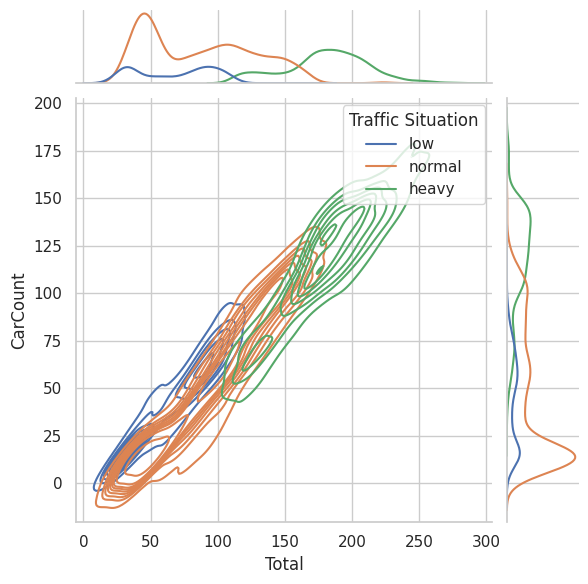

In [ ]:
 #Check if 'Total', 'CarCount', and 'Traffic Situation' exist
if {'Total', 'CarCount', 'Traffic Situation'}.issubset(combined_df.columns):
    # Plot using jointplot
    sns.jointplot(
        data=combined_df,
        x="Total",
        y="CarCount",
        hue="Traffic Situation",
        kind="kde"
    )
    plt.show()
else:
    print("Ensure 'Total', 'CarCount', and 'Traffic Situation' columns exist in the DataFrame.")

Feature Engineering


In [ ]:
combined_df.columns


Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation', 'Source', 'Hour'],
      dtype='object')

In [ ]:
# Distinct Classes in Target variable
combined_df['Traffic Situation'].value_counts()

Traffic Situation
normal    5279
heavy     2511
low       1138
Name: count, dtype: int64

In [ ]:
#Converting target variable 'Traffic Situation' into Numeric form
combined_df['Traffic Situation'] = combined_df['Traffic Situation'].replace({'low':0, 'normal':1,
                                                              'heavy':2, 'high':3})

In [ ]:
#Dealing with 'Day of the week' feature
combined_df['Day of the week'].value_counts()

Day of the week
Thursday     1440
Tuesday      1440
Wednesday    1440
Friday       1152
Monday       1152
Saturday     1152
Sunday       1152
Name: count, dtype: int64

In [ ]:
!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:

# 10. Vehicle count vary by source
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts by Source", "Bike Counts by Source", "Bus Counts by Source", "Truck Counts by Source"))

fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Source', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Source")
fig.update_yaxes(title_text="Count")
fig.show()

In [ ]:
# 10. Vehicle count vary by source
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts by Source", "Bike Counts by Source", "Bus Counts by Source", "Truck Counts by Source"))

fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Source', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Source")
fig.update_yaxes(title_text="Count")
fig.show()

In [ ]:
# Assuming your DataFrame is named 'combined_df'
if 'Day of the week' not in combined_df.columns:
    # If 'Day of the week' column doesn't exist, check for possible variations
    # or rename a similar column if needed.
    print(f"Column 'Day of the week' not found in DataFrame. Available columns: {combined_df.columns}")
    # For example, if you have a column named 'DayOfWeek', rename it:
    # if 'DayOfWeek' in combined_df.columns:
    #     combined_df.rename(columns={'DayOfWeek': 'Day of the week'}, inplace=True)
else:
    # If 'Day of the week' column exists, proceed with the replacement
    combined_df['Day of the week'] = combined_df['Day of the week'].replace({
        'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
        'Friday': 5, 'Saturday': 6, 'Sunday': 7
    })

In [ ]:
# 12. Traffic situation distribution by day of the week
fig = px.box(combined_df, x='Day of the week', y='Traffic Situation', title='Traffic Situation by Day of the Week', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation by Day of the Week', title_x=0.5, xaxis_title='Day of the Week', yaxis_title='Traffic Situation', template='plotly_white')
fig.show()

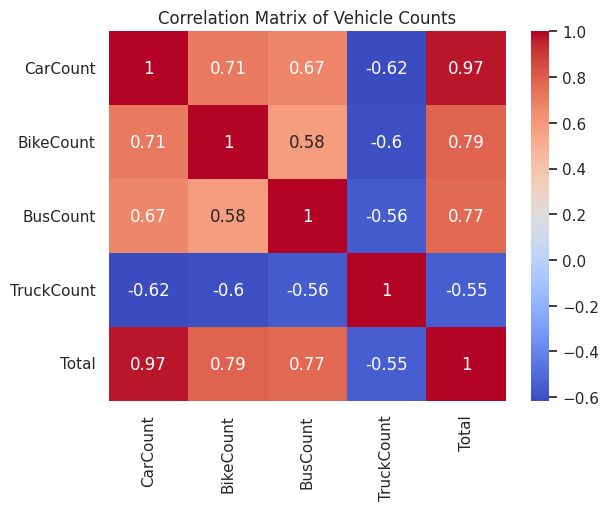

In [ ]:
# 13. Correlations between different vehicle types
corr_matrix = combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Vehicle Counts')
plt.show()

In [ ]:
# 16. Distribution of vehicle counts between weekdays and weekends
combined_df['Weekend'] = combined_df['Day of the week'].isin(['Saturday', 'Sunday'])
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts by Weekend", "Bike Counts by Weekend", "Bus Counts by Weekend", "Truck Counts by Weekend"))

fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Weekend', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Weekend")
fig.update_yaxes(title_text="Count")
fig.show()

In [ ]:
# 18. Distribution of traffic situations by hour
fig = px.box(combined_df, x='Hour', y='Traffic Situation', title='Traffic Situation by Hour', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation by Hour', title_x=0.5, xaxis_title='Hour', yaxis_title='Traffic Situation', template='plotly_white')
fig.show()

In [ ]:
# Calculate average total vehicle count for each source
combined_df['Traffic Situation'] = combined_df['Traffic Situation'].astype('category').cat.codes
avg_source_counts = combined_df.groupby('Source').mean(numeric_only=True).reset_index()
fig = px.bar(avg_source_counts, x='Source', y='Total', title='Average Total Vehicle Count by Source', color_discrete_sequence=['#1f77b4'])
fig.update_layout(title_text='Average Total Vehicle Count by Source', title_x=0.5, xaxis_title='Source', yaxis_title='Average Total Count', template='plotly_white')
fig.show()


In [ ]:
# Calculate average total vehicle count for each source
combined_df['Traffic Situation'] = combined_df['Traffic Situation'].astype('category').cat.codes
avg_source_counts = combined_df.groupby('Source').mean(numeric_only=True).reset_index()
fig = px.bar(avg_source_counts, x='Source', y='Total', title='Average Total Vehicle Count by Source', color_discrete_sequence=['#1f77b4'])
fig.update_layout(title_text='Average Total Vehicle Count by Source', title_x=0.5, xaxis_title='Source', yaxis_title='Average Total Count', template='plotly_white')
fig.show()

In [ ]:
# 20. Distribution of total vehicle counts for each day of the week
fig = px.box(combined_df, x='Day of the week', y='Total', title='Total Vehicle Count by Day of the Week', color_discrete_sequence=['#9467bd'])
fig.update_layout(title_text='Total Vehicle Count by Day of the Week', title_x=0.5, xaxis_title='Day of the Week', yaxis_title='Total Count', template='plotly_white')
fig.show()

In [ ]:
# 22. Variance in vehicle counts across vehicle types
variance_combined_df = combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']].var().reset_index()
variance_combined_df.columns = ['Vehicle Type', 'Variance']
fig = px.bar(variance_combined_df, x='Vehicle Type', y='Variance', title='Variance in Vehicle Counts', color_discrete_sequence=['#ff7f0e'])
fig.update_layout(title_text='Variance in Vehicle Counts', title_x=0.5, xaxis_title='Vehicle Type', yaxis_title='Variance', template='plotly_white')
fig.show()

In [ ]:
# 23. Distribution of vehicle counts by source and day of the week
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts by Source and Day", "Bike Counts by Source and Day", "Bus Counts by Source and Day", "Truck Counts by Source and Day"))

fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Distribution of Vehicle Counts by Source and Day of the Week', title_x=0.5, showlegend=False, template='plotly_white')
fig.show()

In [ ]:
# 25. Peak traffic hours for each vehicle type
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts by Hour", "Bike Counts by Hour", "Bus Counts by Hour", "Truck Counts by Hour"))

fig.add_trace(go.Box(x=combined_df['Hour'], y=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Hour'], y=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Hour'], y=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Hour'], y=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Hour', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Hour")
fig.update_yaxes(title_text="Count")
fig.show()

In [ ]:
# 29. Distribution of traffic situations by date
fig = px.box(combined_df, x='Date', y='Traffic Situation', title='Traffic Situation by Date', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation by Date', title_x=0.5, xaxis_title='Date', yaxis_title='Traffic Situation', template='plotly_white')
fig.show()

In [ ]:
# 26. Average vehicle count for each type change over time
# Exclude non-numeric columns from the mean calculation
numeric_cols = combined_df.select_dtypes(include=['number']).columns

# Group by 'Time' and calculate the mean for numeric columns
avg_time_counts = combined_df.groupby('Time')[numeric_cols].mean().reset_index()

# Create the line plot
fig = px.line(avg_time_counts, x='Time', y=['CarCount', 'BikeCount', 'BusCount', 'TruckCount'], title='Average Vehicle Counts Over Time')
fig.update_layout(title_text='Average Vehicle Counts Over Time', title_x=0.5, xaxis_title='Time', yaxis_title='Average Count', template='plotly_white')

# Display the plot
fig.show()

In [ ]:
combined_df.columns


Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation', 'Source', 'Hour',
       'Weekend'],
      dtype='object')

In [ ]:
# 11. Busiest hours of the day for traffic
combined_df['Hour'] = pd.to_datetime(combined_df['Time'], format='%I:%M:%S %p').dt.hour
fig = px.box(combined_df, x='Hour', y='Total', title='Total Vehicle Count by Hour', color_discrete_sequence=['#9467bd'])
fig.update_layout(title_text='Total Vehicle Count by Hour', title_x=0.5, xaxis_title='Hour', yaxis_title='Total Count', template='plotly_white')
fig.show()

Correlations using HeatMap

In [ ]:
print(combined_df.columns)

Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation', 'Source', 'Hour',
       'Weekend'],
      dtype='object')


In [ ]:
# Check if 'Hour' column exists and create 'AM/PM' if missing
if 'Hour' in combined_df.columns:
    combined_df['AM/PM'] = combined_df['Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
else:
    raise KeyError("The 'Hour' column is missing. Please check your DataFrame.")


In [ ]:
# Check if 'AM/PM' exists, if not, create it based on 'Hour' column
if 'AM/PM' not in combined_df.columns:
    if 'Hour' in combined_df.columns:
        combined_df['AM/PM'] = combined_df['Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
    else:
        raise KeyError("Neither 'AM/PM' nor 'Hour' columns are found in the DataFrame.")

# Select relevant columns
numeric_combined_df = combined_df[['Date', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total',
                                   'Hour', 'AM/PM', 'Traffic Situation']]

# Convert 'Date' to datetime if it's in object type, then to numeric (timestamp)
numeric_combined_df['Date'] = pd.to_numeric(pd.to_datetime(numeric_combined_df['Date']))

# Handle categorical columns by encoding them into numeric
numeric_combined_df['AM/PM'] = numeric_combined_df['AM/PM'].map({'AM': 0, 'PM': 1})

# Encode 'Traffic Situation' (if it's a categorical variable with multiple categories)
numeric_combined_df['Traffic Situation'] = numeric_combined_df['Traffic Situation'].astype('category').cat.codes

# Calculate correlations on the numeric DataFrame
correlation_matrix = numeric_combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)


                           Date  CarCount  BikeCount  BusCount  TruckCount  \
Date               1.000000e+00 -0.011381  -0.001421 -0.007929    0.021765   
CarCount          -1.138136e-02  1.000000   0.711969  0.670301   -0.617304   
BikeCount         -1.420594e-03  0.711969   1.000000  0.576936   -0.600913   
BusCount          -7.929412e-03  0.670301   0.576936  1.000000   -0.556877   
TruckCount         2.176456e-02 -0.617304  -0.600913 -0.556877    1.000000   
Total             -6.905347e-03  0.970887   0.786797  0.770771   -0.547974   
Hour              -1.735328e-17  0.151793   0.125113  0.174810   -0.023197   
AM/PM             -4.103077e-17  0.106493   0.115981  0.144003    0.001083   
Traffic Situation  2.199687e-03  0.610653   0.490725  0.637965   -0.132895   

                      Total          Hour         AM/PM  Traffic Situation  
Date              -0.006905 -1.735328e-17 -4.103077e-17           0.002200  
CarCount           0.970887  1.517931e-01  1.064926e-01          

In [ ]:

# Assuming 'combined_df' is already defined
numeric_combined_df = combined_df[['Date', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total',
                                   'Hour', 'AM/PM', 'Traffic Situation']]  # Selecting relevant columns

# Convert 'Date' to datetime if it's in object type, then to numeric (timestamp)
numeric_combined_df['Date'] = pd.to_numeric(pd.to_datetime(numeric_combined_df['Date']))

# Handle categorical columns (e.g., 'AM/PM' and 'Traffic Situation') by encoding them into numeric
# For 'AM/PM' column, we can map AM to 0 and PM to 1 (or other encoding scheme)
numeric_combined_df['AM/PM'] = numeric_combined_df['AM/PM'].map({'AM': 0, 'PM': 1})

# For 'Traffic Situation', we need to check the unique values and encode them. If it's a string, we can use label encoding
# Example: encode 'Traffic Situation' (if it's a categorical variable with multiple categories)
numeric_combined_df['Traffic Situation'] = numeric_combined_df['Traffic Situation'].astype('category').cat.codes

# Calculate correlations on the numeric DataFrame
correlation_matrix = numeric_combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)


                           Date  CarCount  BikeCount  BusCount  TruckCount  \
Date               1.000000e+00 -0.011381  -0.001421 -0.007929    0.021765   
CarCount          -1.138136e-02  1.000000   0.711969  0.670301   -0.617304   
BikeCount         -1.420594e-03  0.711969   1.000000  0.576936   -0.600913   
BusCount          -7.929412e-03  0.670301   0.576936  1.000000   -0.556877   
TruckCount         2.176456e-02 -0.617304  -0.600913 -0.556877    1.000000   
Total             -6.905347e-03  0.970887   0.786797  0.770771   -0.547974   
Hour              -1.735328e-17  0.151793   0.125113  0.174810   -0.023197   
AM/PM             -4.103077e-17  0.106493   0.115981  0.144003    0.001083   
Traffic Situation  2.199687e-03  0.610653   0.490725  0.637965   -0.132895   

                      Total          Hour         AM/PM  Traffic Situation  
Date              -0.006905 -1.735328e-17 -4.103077e-17           0.002200  
CarCount           0.970887  1.517931e-01  1.064926e-01          

In [ ]:
numeric_combined_df['Date'] = pd.to_numeric(pd.to_datetime(numeric_combined_df['Date']))


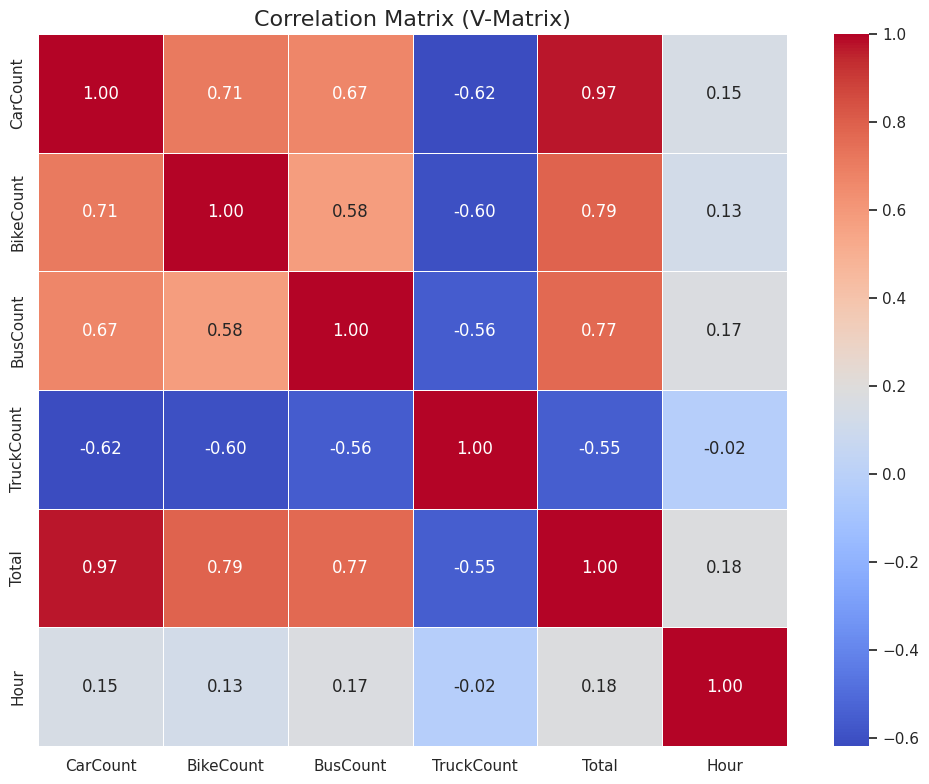

In [ ]:
numeric_columns = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour']

# Calculate the correlation matrix
correlation_matrix = combined_df[numeric_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the heatmap with a color map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title
plt.title('Correlation Matrix (V-Matrix)', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

<Axes: >

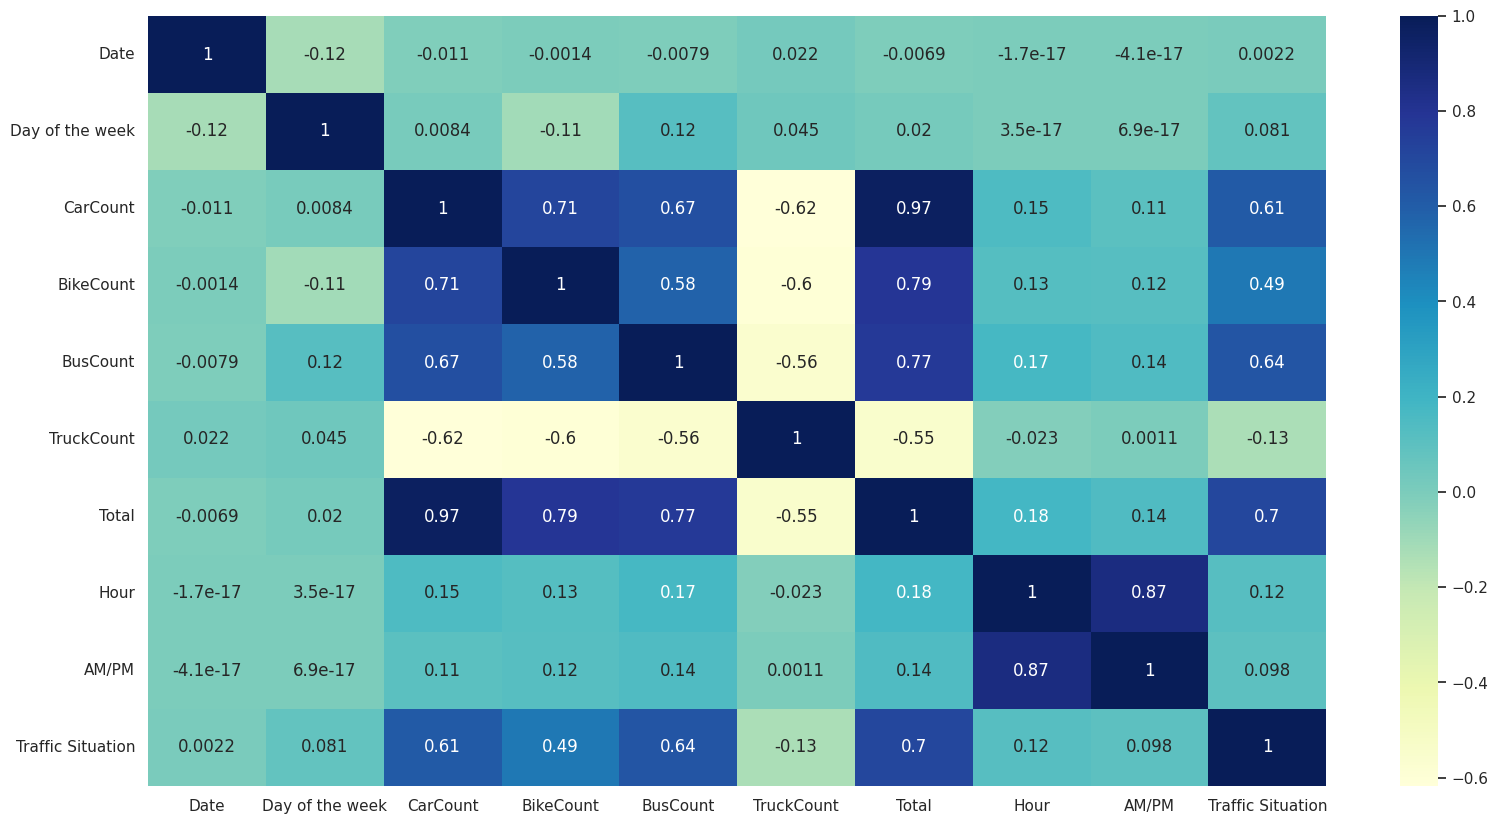

In [ ]:
plt.figure(figsize = (19,10))
# Convert 'AM/PM' and 'Day of the week' to numeric before calculating correlation
combined_df['AM/PM'] = combined_df['AM/PM'].map({'AM': 0, 'PM': 1})  # Map 'AM' to 0 and 'PM' to 1
# Assuming 'Day of the week' is categorical, encode it numerically
combined_df['Day of the week'] = combined_df['Day of the week'].astype('category').cat.codes

sns.heatmap(combined_df[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
           'TruckCount', 'Total', 'Hour', 'AM/PM', 'Traffic Situation']].corr(),
            cmap="YlGnBu",annot=True)

In [ ]:
# Identify and remove outliers
def remove_outliers(combined_df, columns):
    for col in columns:
        Q1 = combined_df[col].quantile(0.25)
        Q3 = combined_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        combined_df = combined_df[(combined_df[col] >= lower_bound) & (combined_df[col] <= upper_bound)]
    return combined_df

vehicle_counts = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
combined_df = remove_outliers(combined_df, vehicle_counts)

In [ ]:
# Check for missing values and duplicates
print("Missing values in each column:")
print(combined_df.isnull().sum())

print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")

Missing values in each column:
Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
Source               0
Hour                 0
Weekend              0
AM/PM                0
dtype: int64
Number of duplicate rows: 0


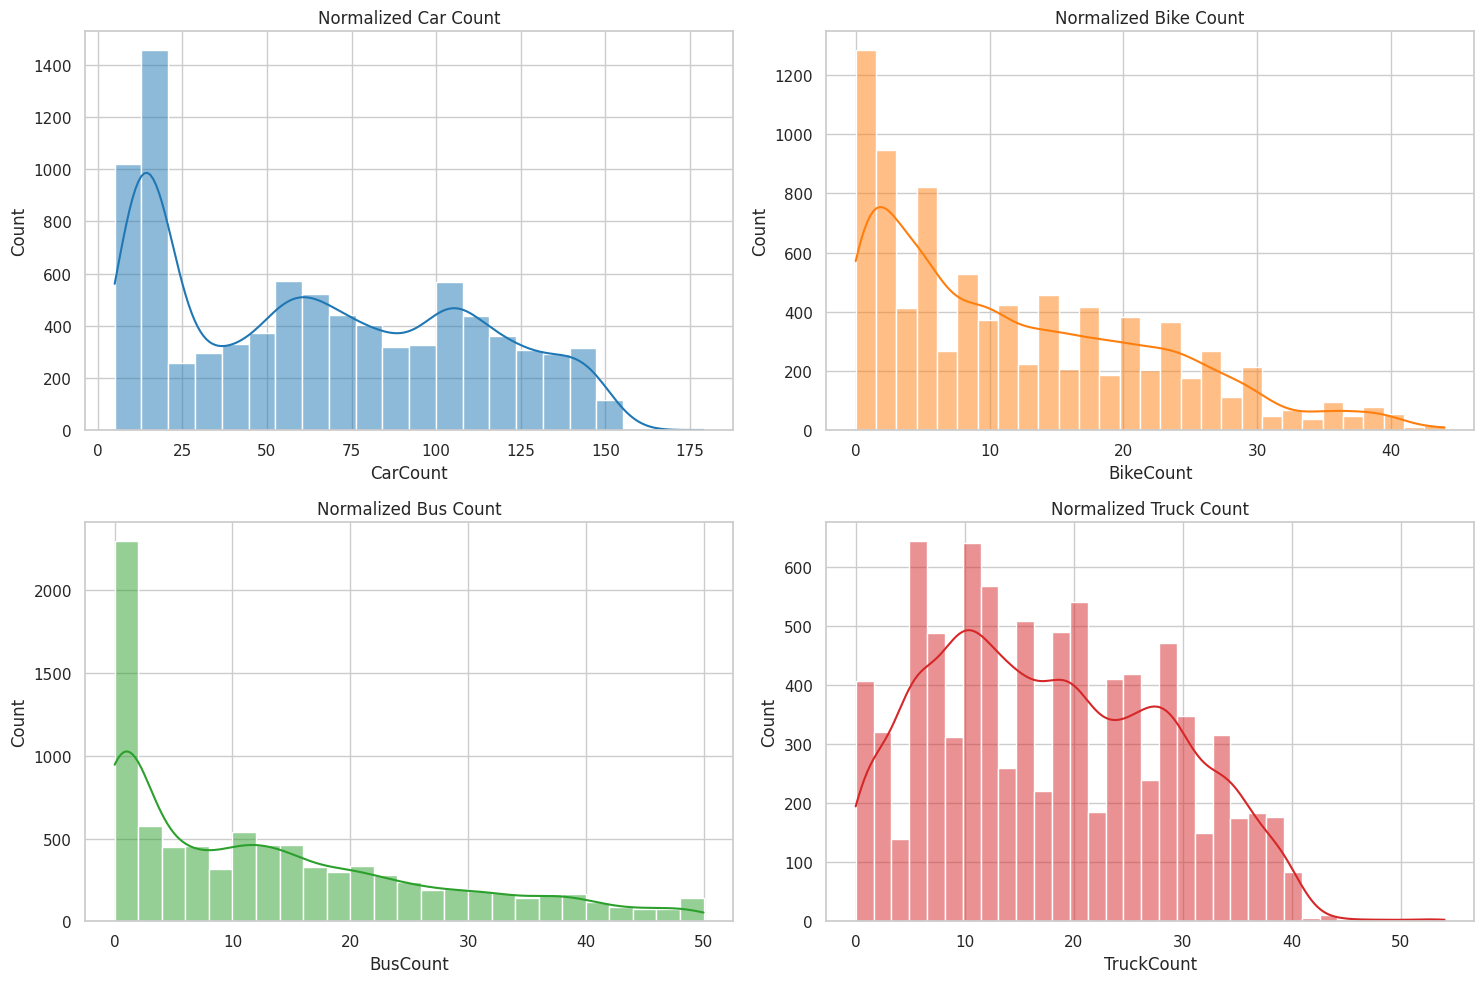

In [ ]:
# Check distribution after normalization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(combined_df['CarCount'], ax=axes[0, 0], kde=True, color='#1f77b4')
sns.histplot(combined_df['BikeCount'], ax=axes[0, 1], kde=True, color='#ff7f0e')
sns.histplot(combined_df['BusCount'], ax=axes[1, 0], kde=True, color='#2ca02c')
sns.histplot(combined_df['TruckCount'], ax=axes[1, 1], kde=True, color='#d62728')
axes[0, 0].set_title('Normalized Car Count')
axes[0, 1].set_title('Normalized Bike Count')
axes[1, 0].set_title('Normalized Bus Count')
axes[1, 1].set_title('Normalized Truck Count')
plt.tight_layout()
plt.show()

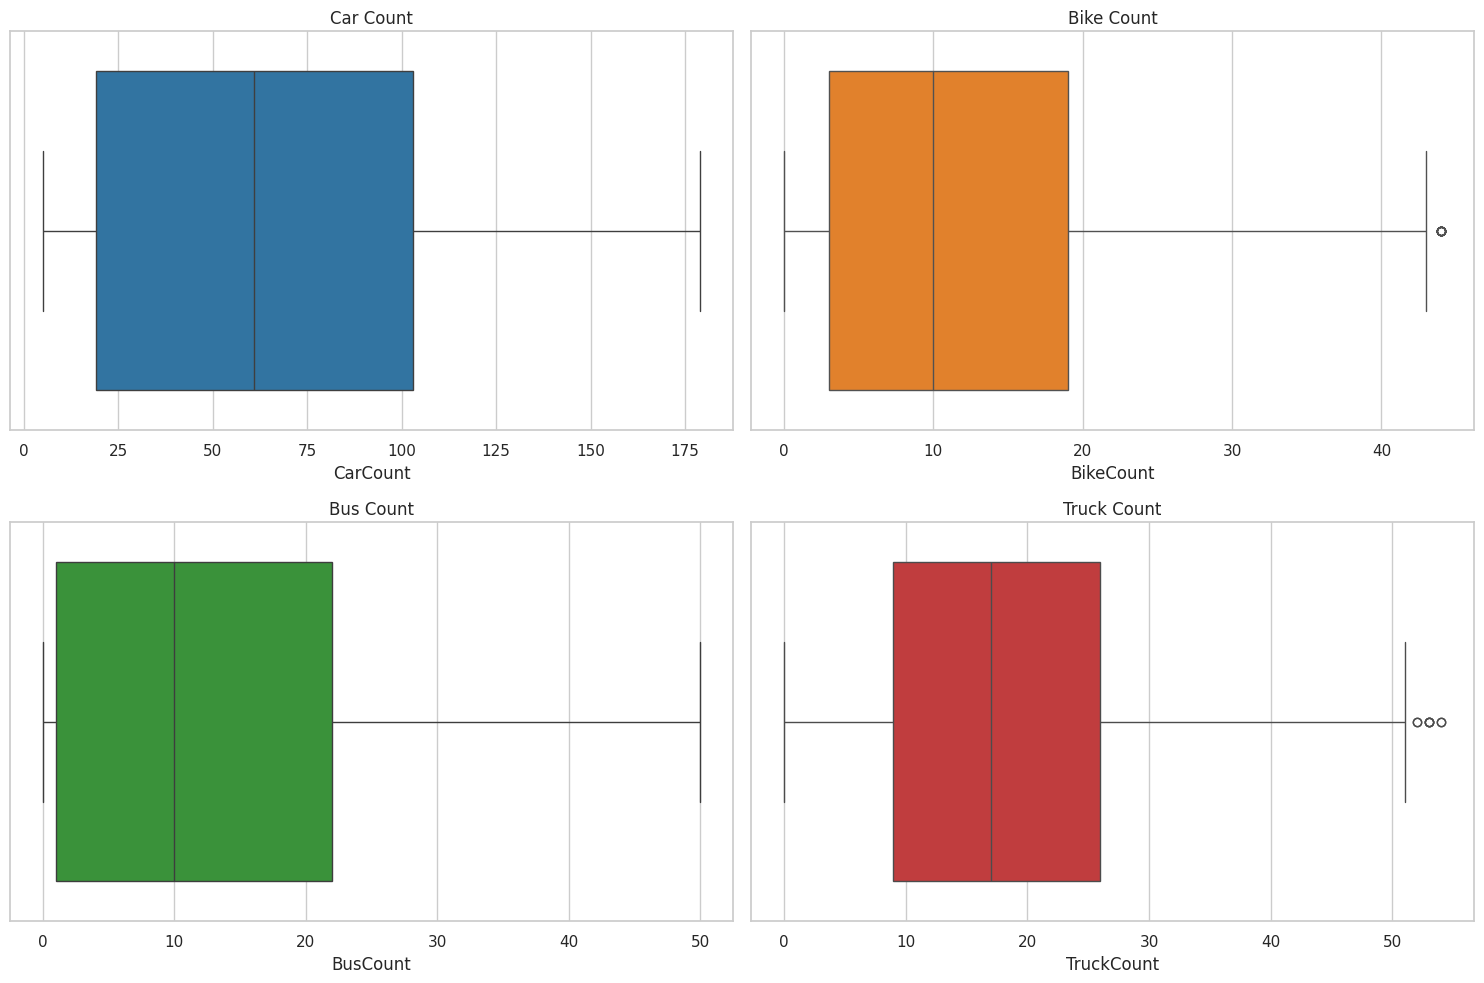

In [ ]:
# Plot boxplots to visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(data=combined_df, x='CarCount', ax=axes[0, 0], color='#1f77b4')
sns.boxplot(data=combined_df, x='BikeCount', ax=axes[0, 1], color='#ff7f0e')
sns.boxplot(data=combined_df, x='BusCount', ax=axes[1, 0], color='#2ca02c')
sns.boxplot(data=combined_df, x='TruckCount', ax=axes[1, 1], color='#d62728')
axes[0, 0].set_title('Car Count')
axes[0, 1].set_title('Bike Count')
axes[1, 0].set_title('Bus Count')
axes[1, 1].set_title('Truck Count')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare the features and target
X = combined_df.drop(columns=['Traffic Situation'])
y = combined_df['Traffic Situation']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline # Import the Pipeline class


In [ ]:
from sklearn.compose import ColumnTransformer # Importing ColumnTransformer
from sklearn.preprocessing import OneHotEncoder # Import OneHotEncoder

# Preprocessing pipeline for numeric and categorical features
numeric_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour']
categorical_features = ['Time', 'Date', 'Day of the week', 'Source', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features) # Assuming OneHotEncoder is already imported
    ])

In [ ]:
# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CarCount', 'BikeCount',
                                                   'BusCount', 'TruckCount',
                                                   'Total', 'Hour']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Time', 'Date',
                                                   'Day of the week', 'Source',
                                                   'Weekend'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
combined_df_selected_columns = combined_df.select_dtypes(include=['int64'])

In [ ]:
from collections import Counter

In [ ]:
def detect_outliers(data, features):
    outlier_indices = []
    for i in features:
        Q1 = np.percentile(data[i], 25)
        Q3 = np.percentile(data[i], 75)

        IQR = Q3 - Q1

        outlier_step = IQR * 1.5
        outlier_list_column = data[(data[i] < Q1 - outlier_step) | (data[i] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_column)

    outlier_indices = Counter(outlier_indices)
    multiple_indices = list(i for i, v in outlier_indices.items() if v > 2)
    return  multiple_indices

In [ ]:
detect_outliers(combined_df, combined_df_selected_columns)

[]

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
combined_df

Time  Date  Day of the week  CarCount  BikeCount  BusCount  \
0     12:00:00 AM    10                5        31          0         4   
1     12:15:00 AM    10                5        49          0         3   
2     12:30:00 AM    10                5        46          0         3   
3     12:45:00 AM    10                5        51          0         2   
4      1:00:00 AM    10                5        57          6        15   
...           ...   ...              ...       ...        ...       ...   
8923  10:45:00 PM     9                4        16          3         1   
8924  11:00:00 PM     9                4        11          0         1   
8925  11:15:00 PM     9                4        15          4         1   
8926  11:30:00 PM     9                4        16          5         0   
8927  11:45:00 PM     9                4        14          3         1   

      TruckCount  Total  Traffic Situation    Source  Hour  Weekend  AM/PM  
0              4     39                  0  OneMonth     0    False      0  
1              3     55                  0  OneMonth     0    False      0  
2              6     55                  0  OneMonth     0    False      0  
3              5     58                  0  OneMonth     0    False      0  
4             16     94                  1  OneMonth     1    False      0  
...          ...    ...                ...       ...   ...      ...    ...  
8923          36     56                  1  TwoMonth    22    False      1  
8924          30     42                  1  TwoMonth    23    False      1  
8925          25     45                  1  TwoMonth    23    False      1  
8926          27     48                  1  TwoMonth    23    False      1  
8927          15     33                  0  TwoMonth    23    False      1  

[8720 rows x 13 columns]

Feature Scaling


In [ ]:
# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns

if not non_numeric_cols.empty:
    print("Non-numeric columns found:", non_numeric_cols)

    # Convert non-numeric columns to numeric using one-hot encoding or label encoding
    X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

# Ensure X is numeric
assert X.select_dtypes(include=['object', 'category']).empty, "Non-numeric columns still exist in X!"

# Apply StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

print("Scaling completed successfully!")

Non-numeric columns found: Index(['Time', 'Source'], dtype='object')
Scaling completed successfully!


In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
X

array([[-0.67008636,  0.87908988, -0.77034157, ..., -0.1003873 ,
        -0.1038273 , -1.42068485],
       [-0.67008636,  0.87908988, -0.35840937, ..., -0.1003873 ,
        -0.1038273 , -1.42068485],
       [-0.67008636,  0.87908988, -0.42706473, ..., -0.1003873 ,
        -0.1038273 , -1.42068485],
       ...,
       [-0.78186142,  0.37102627, -1.13650354, ..., -0.1003873 ,
        -0.1038273 ,  0.70388587],
       [-0.78186142,  0.37102627, -1.11361842, ..., -0.1003873 ,
        -0.1038273 ,  0.70388587],
       [-0.78186142,  0.37102627, -1.15938866, ..., -0.1003873 ,
        -0.1038273 ,  0.70388587]])

In [ ]:
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
# Set random seed
seed = 42

# List of classifiers
models = [
    RandomForestClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    LogisticRegression(random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    KNeighborsClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(random_state=seed),
    CatBoostClassifier(verbose=False)
]

# Parameter grids for each model
rf_param = {
    'max_features': [1, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [False],
    'n_estimators': [100, 300],
    'criterion': ['gini']
}
gradient_param = {
    'loss': ['deviance'],  # Corrected from 'log_loss' to 'deviance'
    'n_estimators': [100, 200, 300],
}
logreg_param = {
    'C': np.linspace(0.1, 10, 7),  # Ensure C values are positive
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 300]
}
dt_param = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(1, 100, 20),
    "min_samples_split": range(10, 500, 20)
}
knn_param = {
    'n_neighbors': np.arange(1, 20, 2),
    'metric': ['euclidean', 'manhattan'],
}
xgb_param = {
    'max_depth': np.arange(1, 100, 20),
}
ada_param = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [100, 200, 300],
}
cat_param = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Parameter grids combined
classifier_param = [
    rf_param,
    gradient_param,
    logreg_param,
    dt_param,
    knn_param,
    xgb_param,
    ada_param,
    cat_param,


]

# Results storage
results = []
clf_best_score = []
clf_best_estimators = []


In [ ]:

# Grid Search for each model
for i in range(len(models)):
    clf = GridSearchCV(models[i], classifier_param[i], scoring='accuracy', verbose=1, cv=10, n_jobs=-1)
    clf.fit(X_train, y_encoded_train)
    clf_best_score.append(clf.best_score_)
    clf_best_estimators.append(clf.best_estimator_)
    results.append({"Algorithm": type(models[i]).__name__, "Best Estimators": clf_best_estimators[i], "Accuracy": clf_best_score[i]})

# Create a DataFrame of results
results_combined_df = pd.DataFrame(results)
results_combined_df.sort_values(by='Accuracy', ascending=False, inplace=True)
print(results_combined_df)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
                    Algorithm  \
7          CatBoostClassifier   
5               XGBClassifier   
1  GradientBoostingClassifier   
0      RandomForestClassifier   
2          LogisticRegression   
6          AdaBoostClassifier   
4        KNeighborsClassifier   
3      DecisionTreeClassifier   

                                     Best Estimators  Accuracy  
7  <catboost.core.CatBoostClassifier object at 0x...  0.999237  
5  XGBClassifier(base_score=None, booster=None, c...  0.998855  
1  ([Deci

In [ ]:

# Voting Classifier
votingC = VotingClassifier(
    estimators=[
        ('XGB', clf_best_estimators[5]),
        ('DT', clf_best_estimators[3]),
        ('GR', clf_best_estimators[1]),
        ('RF', clf_best_estimators[0]),
        ('cat', clf_best_estimators[7]),
        ('ada', clf_best_estimators[6]),

    ],
    voting='soft', n_jobs=-1
)
votingC.fit(X_train, y_encoded_train)


VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                                     min_samples_split=1

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List of classifiers for evaluation
clfs = [
    LogisticRegression(random_state=seed),
    RandomForestClassifier(random_state=seed),
    SVC(probability=True, random_state=seed),
    XGBClassifier(random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    KNeighborsClassifier(),
    CatBoostClassifier(verbose=False)
]

# Labels for the classifiers
labels = [
    'Logistic Regression', 'Random Forest', 'SVC', 'XGBoost', 'AdaBoost',
    'Gradient Boosting', 'Decision Tree', 'KNeighbors', 'CatBoost'
]

# Evaluate classifiers using cross-validation
for clf, label in zip(clfs, labels):
    # Get cross-validated predictions
    y_pred = cross_val_predict(clf, X_train, y_encoded_train, cv=5)

    # Calculate metrics
    acc = accuracy_score(y_encoded_train, y_pred)
    precision = precision_score(y_encoded_train, y_pred, average='weighted')
    recall = recall_score(y_encoded_train, y_pred, average='weighted')
    f1 = f1_score(y_encoded_train, y_pred, average='weighted')

    # Print results
    print(f"{label}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1-Score : {f1:.4f}")
    print("-" * 40)


Logistic Regression:
  Accuracy : 0.8742
  Precision: 0.8734
  Recall   : 0.8742
  F1-Score : 0.8736
----------------------------------------
Random Forest:
  Accuracy : 0.9660
  Precision: 0.9661
  Recall   : 0.9660
  F1-Score : 0.9659
----------------------------------------
SVC:
  Accuracy : 0.7699
  Precision: 0.7736
  Recall   : 0.7699
  F1-Score : 0.7315
----------------------------------------
XGBoost:
  Accuracy : 0.9992
  Precision: 0.9992
  Recall   : 0.9992
  F1-Score : 0.9992
----------------------------------------
AdaBoost:
  Accuracy : 0.7947
  Precision: 0.8369
  Recall   : 0.7947
  F1-Score : 0.7378
----------------------------------------
Gradient Boosting:
  Accuracy : 0.9985
  Precision: 0.9985
  Recall   : 0.9985
  F1-Score : 0.9985
----------------------------------------
Decision Tree:
  Accuracy : 0.9962
  Precision: 0.9962
  Recall   : 0.9962
  F1-Score : 0.9962
----------------------------------------
KNeighbors:
  Accuracy : 0.7542
  Precision: 0.7417
  Recal

In [ ]:
# Make predictions using the Voting Classifier
y_pred = votingC.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_encoded_test, y_pred)
precision = precision_score(y_encoded_test, y_pred, average='weighted')
recall = recall_score(y_encoded_test, y_pred, average='weighted')
f1 = f1_score(y_encoded_test, y_pred, average='weighted')

# Print the results
print("Voting Classifier Metrics:")
print(f"  Accuracy : {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall   : {recall:.4f}")
print(f"  F1-Score : {f1:.4f}")

Voting Classifier Metrics:
  Accuracy : 0.9985
  Precision: 0.9985
  Recall   : 0.9985
  F1-Score : 0.9985


In [ ]:
cl1 = LogisticRegression() # Logistic Regression
cl2 = RandomForestClassifier()  # Random Forest
cl3 = SVC()  # SVC
cl4 = XGBClassifier()  # XGBoost
cl5 = AdaBoostClassifier()  # AdaBoost
cl6=GradientBoostingClassifier()
cl7=DecisionTreeClassifier()
cl8=KNeighborsClassifier()
cl9=CatBoostClassifier()




for clf, label in zip([cl1, cl2, cl3, cl4, cl5], ['lr', 'rf', 'svc', 'xgb', 'ada']):
    scores = cross_val_score(clf, X_train, y_encoded_train, scoring='accuracy', cv=5)  # Use X_train and y_encoded_train
    print('Accuracy: ', (scores.mean(), label))

Accuracy:  (0.8742384656926424, 'lr')
Accuracy:  (0.9686563134003766, 'rf')
Accuracy:  (0.7698765197845665, 'svc')
Accuracy:  (0.9992359114328668, 'xgb')
Accuracy:  (0.7947272780348256, 'ada')


In [ ]:
voting_cl = VotingClassifier(estimators = [('lr',cl1),('rf',cl2),('svc',cl3),
                                          ('xgb',cl4),('ada',cl5)], voting = 'hard')

# Replace 'train_X' and 'train_y' with 'X_train' and 'y_encoded_train'
voting_cl.fit(X_train, y_encoded_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow...
                                            importance_type=None,
                                            interaction_constraints=None,
   

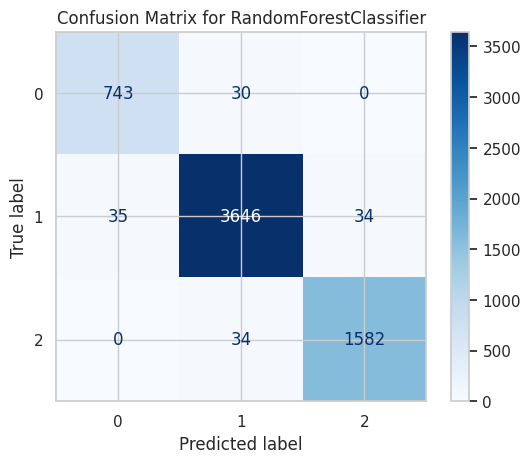

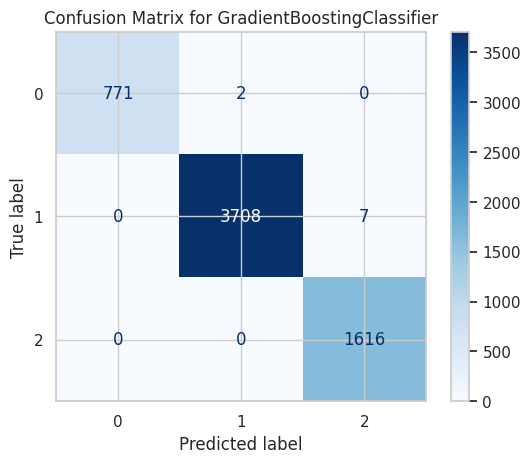

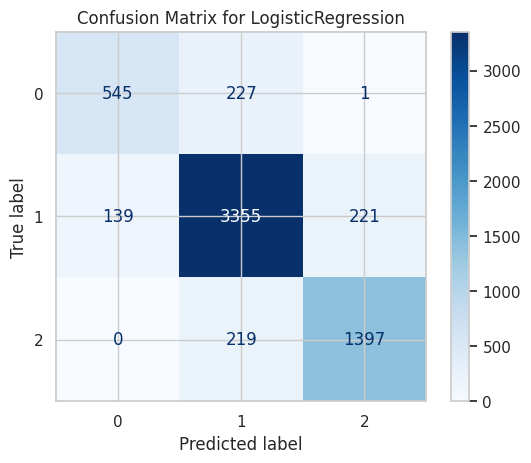

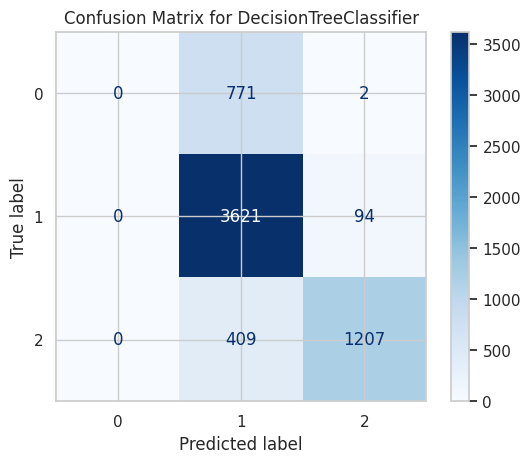

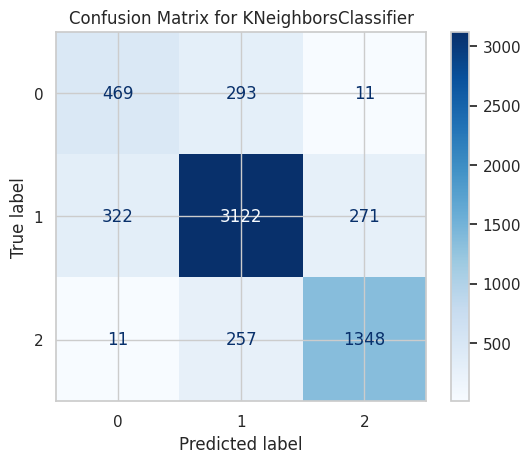

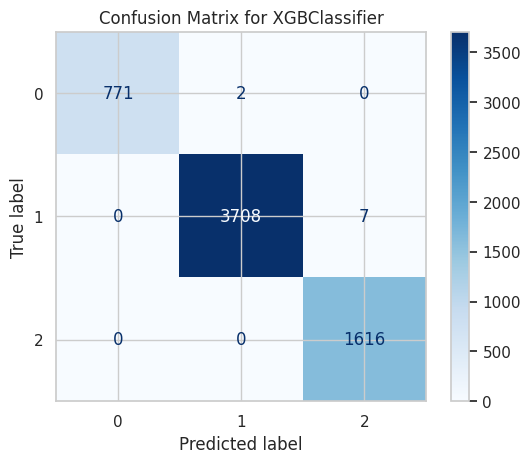

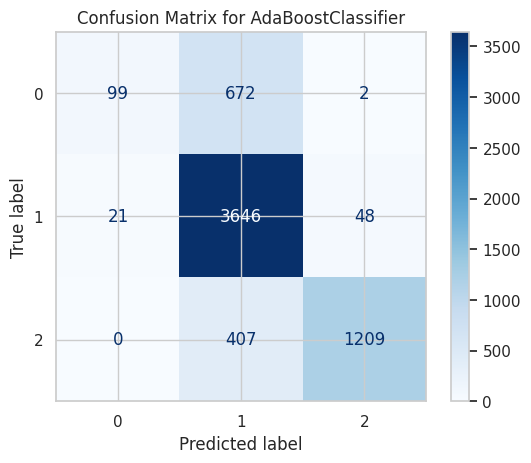

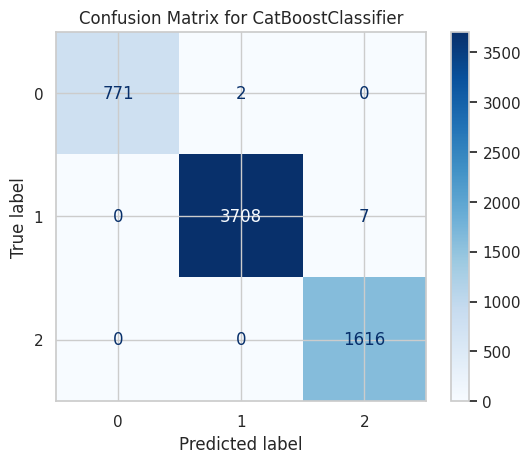

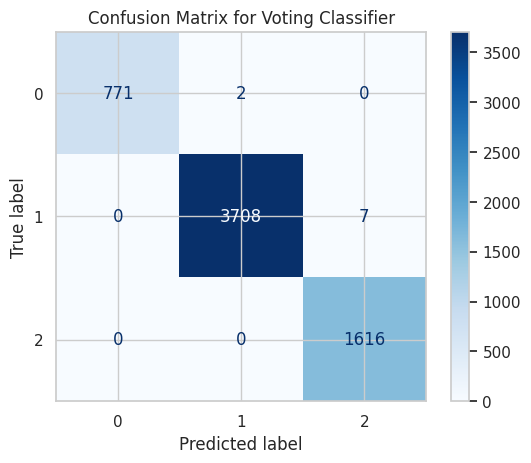

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate and display confusion matrix for each model
for i, estimator in enumerate(clf_best_estimators):
    # Make predictions
    y_pred = estimator.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_encoded_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_encoded_test))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {type(estimator).__name__}")
    plt.show()

# Confusion matrix for the Voting Classifier
y_pred_voting = votingC.predict(X_test)
cm_voting = confusion_matrix(y_encoded_test, y_pred_voting)
disp_voting = ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=np.unique(y_encoded_test))
disp_voting.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Voting Classifier")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the target variable for multi-class ROC curve
y_test_binarized = label_binarize(y_encoded_test, classes=np.unique(y_encoded_test))
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

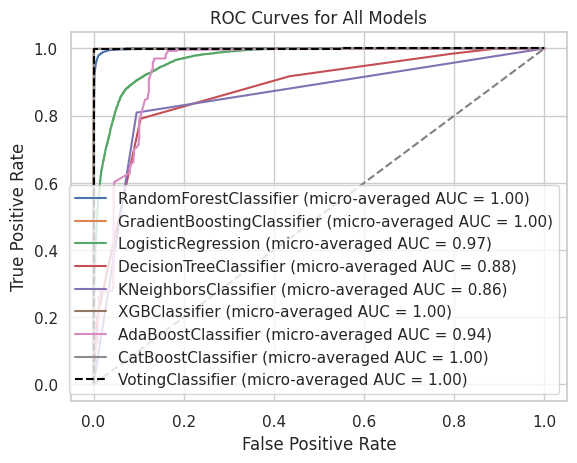

In [ ]:

# Generate ROC curves for each model
for i, estimator in enumerate(clf_best_estimators):
    try:
        # Get predicted probabilities for all classes
        y_proba = estimator.predict_proba(X_test)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(n_classes):
            fpr[j], tpr[j], _ = roc_curve(y_test_binarized[:, j], y_proba[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Plot the micro-averaged ROC curve
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f"{type(estimator).__name__} (micro-averaged AUC = {roc_auc['micro']:.2f})")
    except AttributeError:
        print(f"Estimator {type(estimator).__name__} does not have predict_proba method. Skipping ROC curve.")

# ROC for the Voting Classifier
try:
    y_proba_voting = votingC.predict_proba(X_test)
    fpr_voting = dict()
    tpr_voting = dict()
    roc_auc_voting = dict()
    for j in range(n_classes):
        fpr_voting[j], tpr_voting[j], _ = roc_curve(y_test_binarized[:, j], y_proba_voting[:, j])
        roc_auc_voting[j] = auc(fpr_voting[j], tpr_voting[j])

    # Plot the micro-averaged ROC curve for Voting Classifier
    fpr_voting["micro"], tpr_voting["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba_voting.ravel())
    roc_auc_voting["micro"] = auc(fpr_voting["micro"], tpr_voting["micro"])
    plt.plot(fpr_voting["micro"], tpr_voting["micro"],
             label=f"VotingClassifier (micro-averaged AUC = {roc_auc_voting['micro']:.2f})", linestyle='--', color='black')
except AttributeError:
    print("VotingClassifier does not have predict_proba method. Skipping ROC curve.")

# Add plot details
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

In [ ]:
from sklearn.inspection import permutation_importance

# Function to calculate and plot feature importances
def plot_feature_importances(model, model_name, X_train, feature_names, y_train=None):
    if hasattr(model, "feature_importances_"):  # Tree-based models
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):  # Linear models
        # Fix: Use coef_ directly instead of flattening it
        importances = np.abs(model.coef_[0])
    else:  # Use permutation importance as a fallback
        print(f"Calculating permutation importance for {model_name}...")
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, scoring="accuracy")
        importances = result.importances_mean

    # Create DataFrame
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
    plt.title(f'Top 10 Feature Importances: {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()